# Integrate Multi Samples




In [1]:
import os
os.environ["EPIONE_DATA_DIR"] = "/Users/fernandozeng/Desktop/analysis/25_epione/code/tutorial/genome"

import epione as epi
import snapatac2 as snap
import scanpy as sc
import matplotlib.pyplot as plt

epi.pl.plot_set()

%load_ext autoreload
%autoreload 2

/Users/fernandozeng/miniforge3/envs/scanpy/lib/python3.10/site-packages/sorted_nearest/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


└─ 🔬 Starting plot initialization...
  ├─ Apply Scanpy/matplotlib settings
  ├─ Custom font setup
  ├─ Suppress warnings
  ├─ 
___________      .__                      
\_   _____/_____ |__| ____   ____   ____  
 |    __)_\____ \|  |/  _ \ /    \_/ __ \ 
 |        \  |_> >  (  <_> )   |  \  ___/ 
/_______  /   __/|__|\____/|___|  /\___  >
        \/|__|                  \/     \/ 

  ├─ 🔖 Version: 0.0.1rc1   📚 Tutorials: https://epione.readthedocs.io/
└─ ✅ plot_set complete.



## Data Preparation

### Import Data

For scATAC-seq data, we recommend starting your analysis from the fragment.tsv file. This is because the peak contents in the Cellranger-ATAC output matrix are inconsistent. Although Epione provides a peak merging function, it is still advisable to begin your analysis from the fragment level.

In [109]:
files=[
    ('scATAC_BMMC_R1','data/scATAC_BMMC_R1.fragments.tsv.gz'),
    ('scATAC_CD34_BMMC_R1','data/scATAC_CD34_BMMC_R1.fragments.tsv.gz'),
    ('scATAC_PBMC_R1','data/scATAC_PBMC_R1.fragments.tsv.gz')
]

In [111]:
%%time
adatas = epi.pp.import_fragments(
    [fl for _, fl in files],
    file=['result/'+name + '.h5ad' for name, _ in files],
    chrom_sizes=epi.utils.genome.hg19,
    min_num_fragments=1000,
    sorted_by_barcode=False,
)
adatas

  0%|                                                                                     | 0/3 [00:00<?, ?it/s]/Users/fernandozeng/miniforge3/envs/scanpy/lib/python3.10/site-packages/sorted_nearest/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/fernandozeng/miniforge3/envs/scanpy/lib/python3.10/site-packages/sorted_nearest/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/fernandozeng/miniforge3/envs/scanpy/lib/python3.10/site-packages/sorted_nearest/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. 

CPU times: user 30.1 ms, sys: 86.6 ms, total: 117 ms
Wall time: 38.8 s


[AnnData object with n_obs x n_vars = 5000 x 0 backed at 'result/scATAC_BMMC_R11.h5ad'
     obs: 'n_fragment', 'frac_dup', 'frac_mito'
     uns: 'reference_sequences'
     obsm: 'fragment_paired',
 AnnData object with n_obs x n_vars = 3393 x 0 backed at 'result/scATAC_CD34_BMMC_R11.h5ad'
     obs: 'n_fragment', 'frac_dup', 'frac_mito'
     uns: 'reference_sequences'
     obsm: 'fragment_paired',
 AnnData object with n_obs x n_vars = 2496 x 0 backed at 'result/scATAC_PBMC_R11.h5ad'
     obs: 'n_fragment', 'frac_dup', 'frac_mito'
     uns: 'reference_sequences'
     obsm: 'fragment_paired']

### Merge data

It is important to note that we should perform quality control on each adata dataset individually. However, since this section focuses on how to integrate and analyze data, the next step is data merging.

In [119]:
%%time
data = snap.AnnDataSet(
    adatas=[(name, adata) for (name, _), adata in zip(files, adatas)],
    filename="data/pbmc_new.h5ads"
)
data

CPU times: user 8.76 ms, sys: 3.98 ms, total: 12.7 ms
Wall time: 19.9 ms


AnnDataSet object with n_obs x n_vars = 10889 x 0 backed at 'data/pbmc_new.h5ads'
contains 3 AnnData objects with keys: 'scATAC_BMMC_R1', 'scATAC_CD34_BMMC_R1', 'scATAC_PBMC_R1'
    obs: 'sample'
    uns: 'reference_sequences', 'AnnDataSet'

### Peak Calling

If we have already annotated the data, we can obtain more meaningful peaks during peak calling. However, we can also perform peak calling before annotation. This means that at Epione, the optimal approach is to conduct peak calling twice: once now and once after annotation.

In [120]:
%%time
snap.tl.macs3(data, groupby=None, replicate='sample')

2025-10-08 12:23:47 - INFO - [1571 MB] #3 Pre-compute pvalue-qvalue table...
2025-10-08 12:26:54 - INFO - [2475 MB] #3 Call peaks for each chromosome...


CPU times: user 4min 56s, sys: 5.47 s, total: 5min 1s
Wall time: 5min 3s


In [121]:
%%time
merged_peaks = epi.utils.merge_peaks(data.uns['macs3_pseudobulk'], epi.utils.hg19)
merged_peaks.head()

CPU times: user 257 ms, sys: 20.2 ms, total: 277 ms
Wall time: 283 ms


Peaks,sample0
str,bool
"""chr1:237511-238012""",true
"""chr1:540710-541211""",true
"""chr1:565073-565574""",true
"""chr1:569153-569654""",true
"""chr1:713849-714350""",true


In [122]:
%%time
peak_mat = epi.pp.make_peak_matrix(data, use_rep=merged_peaks['Peaks'])
peak_mat

CPU times: user 19.2 s, sys: 681 ms, total: 19.9 s
Wall time: 5.04 s


AnnData object with n_obs × n_vars = 10889 × 148866
    obs: 'sample'

Since we are using `anndata-rs` to read data stored on the hard disk, we need to perform a close operation to ensure data integrity and security.

In [ ]:
data.close()

In [ ]:
peak_mat.write('data/pbmc_peak_calling.h5ad')

## Batch correction

Sometimes the iterative LSI approach isnt enough of a correction for strong batch effect differences. For this reason, Epione implements a commonly used batch effect correction tool called Harmony which was originally designed for scRNA-seq. We provide a wrapper that will pass a dimensionality reduction object from Epione directly to the harmony function.

### Harmony

In [125]:
epi.tl.lsi(
    peak_mat,
    n_components=100
)

  └─ Starting optimized LSI analysis...
  └─ Computing TF-IDF normalization...
  └─ Applying L1 normalization and log transformation...
  └─ Performing randomized SVD...
  └─ Standardizing embeddings...
  └─ Removing first component (typically associated with peak count per cell)
  └─ LSI analysis completed!


In [126]:
sc.external.pp.harmony_integrate(
    peak_mat,
    key='sample',
    basis='X_lsi',
    adjusted_basis='X_lsi_harmony'
)
peak_mat

2025-10-08 12:29:05,556 - harmonypy - INFO - [3122 MB] Computing initial centroids with sklearn.KMeans...
2025-10-08 12:29:05 - INFO - [3122 MB] Computing initial centroids with sklearn.KMeans...
2025-10-08 12:29:09,547 - harmonypy - INFO - [3122 MB] sklearn.KMeans initialization complete.
2025-10-08 12:29:09 - INFO - [3122 MB] sklearn.KMeans initialization complete.
2025-10-08 12:29:09,581 - harmonypy - INFO - [3122 MB] Iteration 1 of 10
2025-10-08 12:29:09 - INFO - [3122 MB] Iteration 1 of 10
2025-10-08 12:29:11,086 - harmonypy - INFO - [3122 MB] Iteration 2 of 10
2025-10-08 12:29:11 - INFO - [3122 MB] Iteration 2 of 10
2025-10-08 12:29:12,477 - harmonypy - INFO - [3122 MB] Converged after 2 iterations
2025-10-08 12:29:12 - INFO - [3122 MB] Converged after 2 iterations


AnnData object with n_obs × n_vars = 10889 × 148866
    obs: 'sample'
    obsm: 'X_lsi', 'X_lsi_harmony'

In [4]:
epi.pp.neighbors(peak_mat, use_rep="X_lsi_harmony", n_neighbors=15, n_pcs=30)
epi.tl.umap(peak_mat)

Computing neighbors with n_neighbors=15
Finished computing neighbors
    Added to .uns['neighbors']
    .obsp['distances'], distances for each pair of neighbors
    .obsp['connectivities'], weighted adjacency matrix
Computing UMAP embedding...
    Finished computing UMAP
    Added:
        'X_umap', UMAP coordinates (adata.obsm)
        'umap', UMAP parameters (adata.uns)


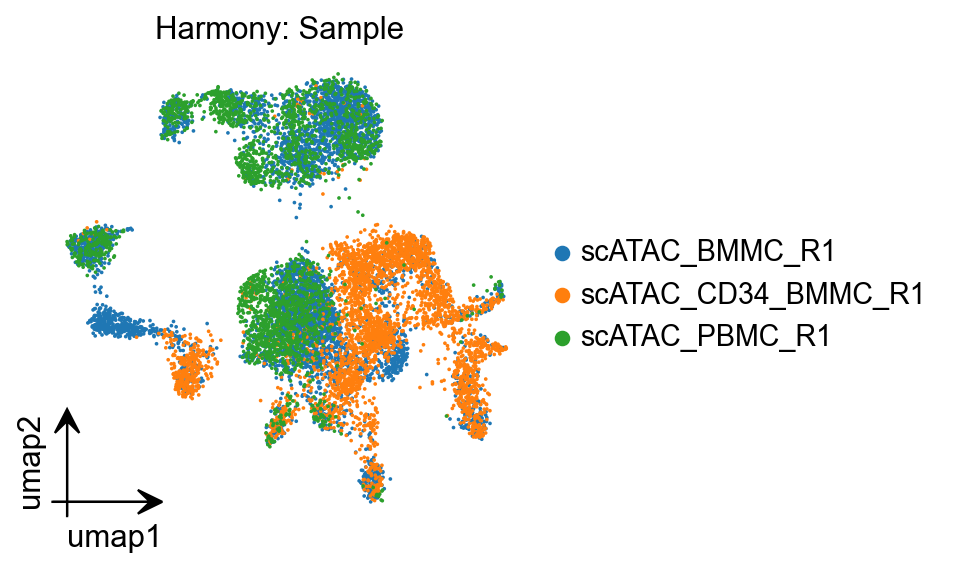

In [8]:
%matplotlib inline
epi.pl.umap(
    peak_mat,
    #basis='X_umap',
    color='sample',
    title='Harmony: Sample',
    cmap='RdBu_r',
    vmin=0,
)

In [16]:
sc.tl.leiden(peak_mat)

running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


In [ ]:
peak_mat.write('data/pbmc_peak_mat.h5ad')

In [3]:
#peak_mat=sc.read('data/pbmc_peak_mat.h5ad')

## Gene Activity

Interestingly, we can also calculate the activity of each gene. For multiple samples, we need to compute them separately and then combine the results.

In [14]:
gene_act_dict={}
for name in ['scATAC_PBMC_R1',
             'scATAC_BMMC_R1',
            'scATAC_CD34_BMMC_R1']:

    data1=snap.read(f'result/{name}.h5ad')
    gene_matrix1 = epi.pp.make_gene_matrix(data1, 
                                           epi.utils.genome.hg19)
    gene_matrix1.obs['sample']=name
    gene_act_dict[name]=gene_matrix1

In [10]:
gene_act_dict

{'scATAC_PBMC_R1': AnnData object with n_obs × n_vars = 2496 × 61345
     obs: 'n_fragment', 'frac_dup', 'frac_mito',
 'scATAC_BMMC_R1': AnnData object with n_obs × n_vars = 2496 × 61345
     obs: 'n_fragment', 'frac_dup', 'frac_mito',
 'scATAC_CD34_BMMC_R1': AnnData object with n_obs × n_vars = 2496 × 61345
     obs: 'n_fragment', 'frac_dup', 'frac_mito'}

In [15]:
gene_act=sc.concat(
    gene_act_dict,
    merge='same'
)
gene_act

AnnData object with n_obs × n_vars = 10889 × 61345
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'sample'

In [18]:
gene_act.obs_names_make_unique()
peak_mat.obs_names_make_unique()

In [20]:
gene_act=gene_act[peak_mat.obs.index]
gene_act.obs['leiden']=peak_mat.obs['leiden']
gene_act.obsm=peak_mat.obsm.copy()
gene_act.obsp=peak_mat.obsp.copy()

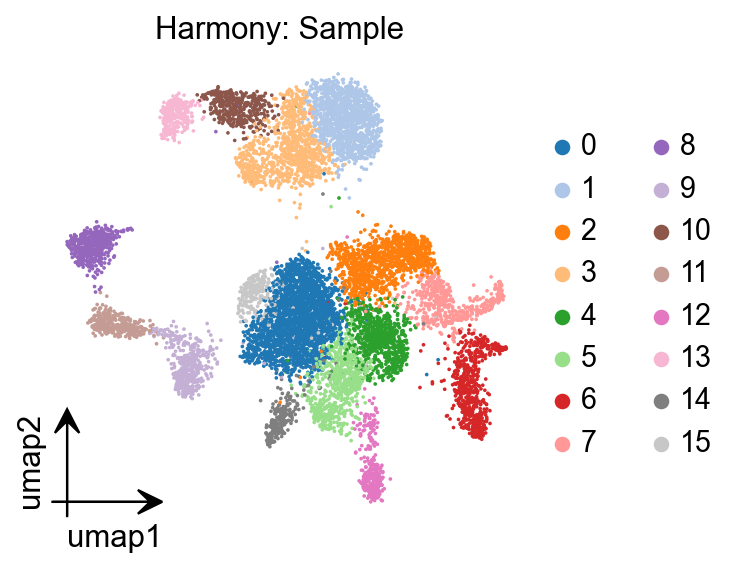

In [22]:
%matplotlib inline
epi.pl.umap(
    gene_act,
    #basis='X_umap',
    color='leiden',
    title='Harmony: Sample',
    cmap='RdBu_r',
    vmin=0,
)

In [23]:
gene_act.write('data/pbmc_gene_act.h5ad')

... storing 'sample' as categorical


In [48]:
gene_act=sc.read('data/pbmc_gene_act.h5ad')

### Preprocess Gene Activity

To do this cell type annotation when we only have scATAC-seq data available, we use prior knowledge of cell type-specific marker genes and we estimate gene expression for these genes from our chromatin accessibility data by uing gene scores. A gene score is essentially a prediction of how highly expressed a gene will be based on the accessibility of regulatory elements in the vicinity of the gene.

In [51]:
sc.pp.filter_genes(gene_act, min_cells=100)

filtered out 21944 genes that are detected in less than 100 cells


In [52]:
# Saving count data
gene_act.layers["counts"] = gene_act.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(gene_act)
# Logarithmize the data
sc.pp.log1p(gene_act)

normalizing counts per cell
    finished (0:00:00)


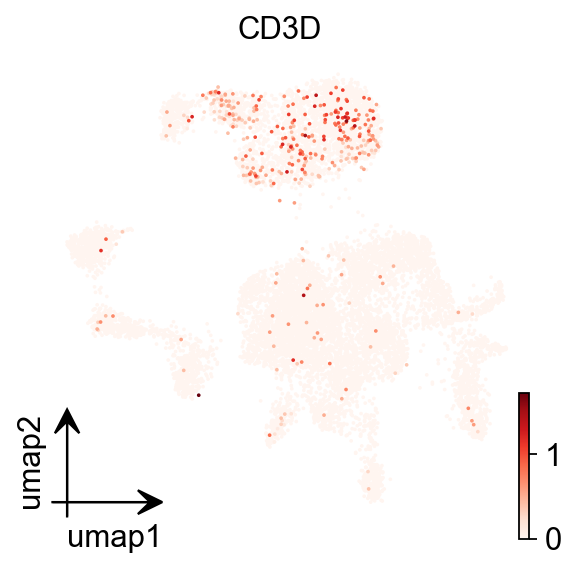

In [53]:
epi.pl.umap(
    gene_act,
    #basis='X_umap',
    color='CD3D',
    #title='Harmony: Sample',
    cmap='Reds',
    vmin=0,
)

### Genes Imputation with MAGIC

In the previous section, you may have noticed that some of the gene score plots appear quite variable. This is because of the sparsity of scATAC-seq data. We can use MAGIC to impute gene scores by smoothing signal across nearby cells. In our hands, this greatly improves the visual interpretation of gene scores.

In [54]:
sc.external.pp.magic(gene_act, name_list="all_genes", knn=5)

computing MAGIC
  Running MAGIC with `solver='exact'` on 30114-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
    finished (0:02:17)


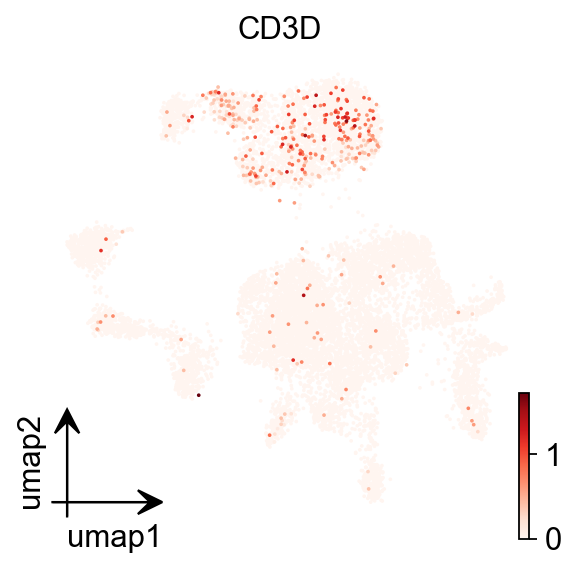

In [55]:
epi.pl.umap(
    gene_act,
    #basis='X_umap',
    color='CD3D',
    #title='Harmony: Sample',
    cmap='Reds',
    vmin=0,
)

In [27]:
sc.pp.highly_variable_genes(gene_act, n_top_genes=2000, )
gene_act.raw=gene_act.copy()
gene_act=gene_act[:,gene_act.var.highly_variable]
gene_act

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


View of AnnData object with n_obs × n_vars = 10889 × 2000
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'sample', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'rank_genes_groups', 'log1p', 'hvg'
    obsm: 'X_lsi', 'X_lsi_harmony', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

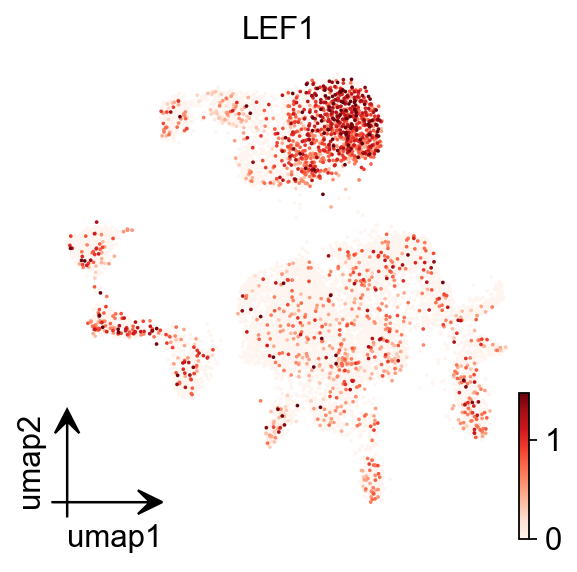

In [73]:
epi.pl.umap(
    gene_act,
    #basis='X_umap',
    color='LEF1',
    #title='Harmony: Sample',
    cmap='Reds',
    vmax='p99.2',
)

## Annotation



In [58]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(gene_act, 
                        groupby="leiden", 
                        method="wilcoxon")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


Storing dendrogram info using `.uns['dendrogram_leiden']`


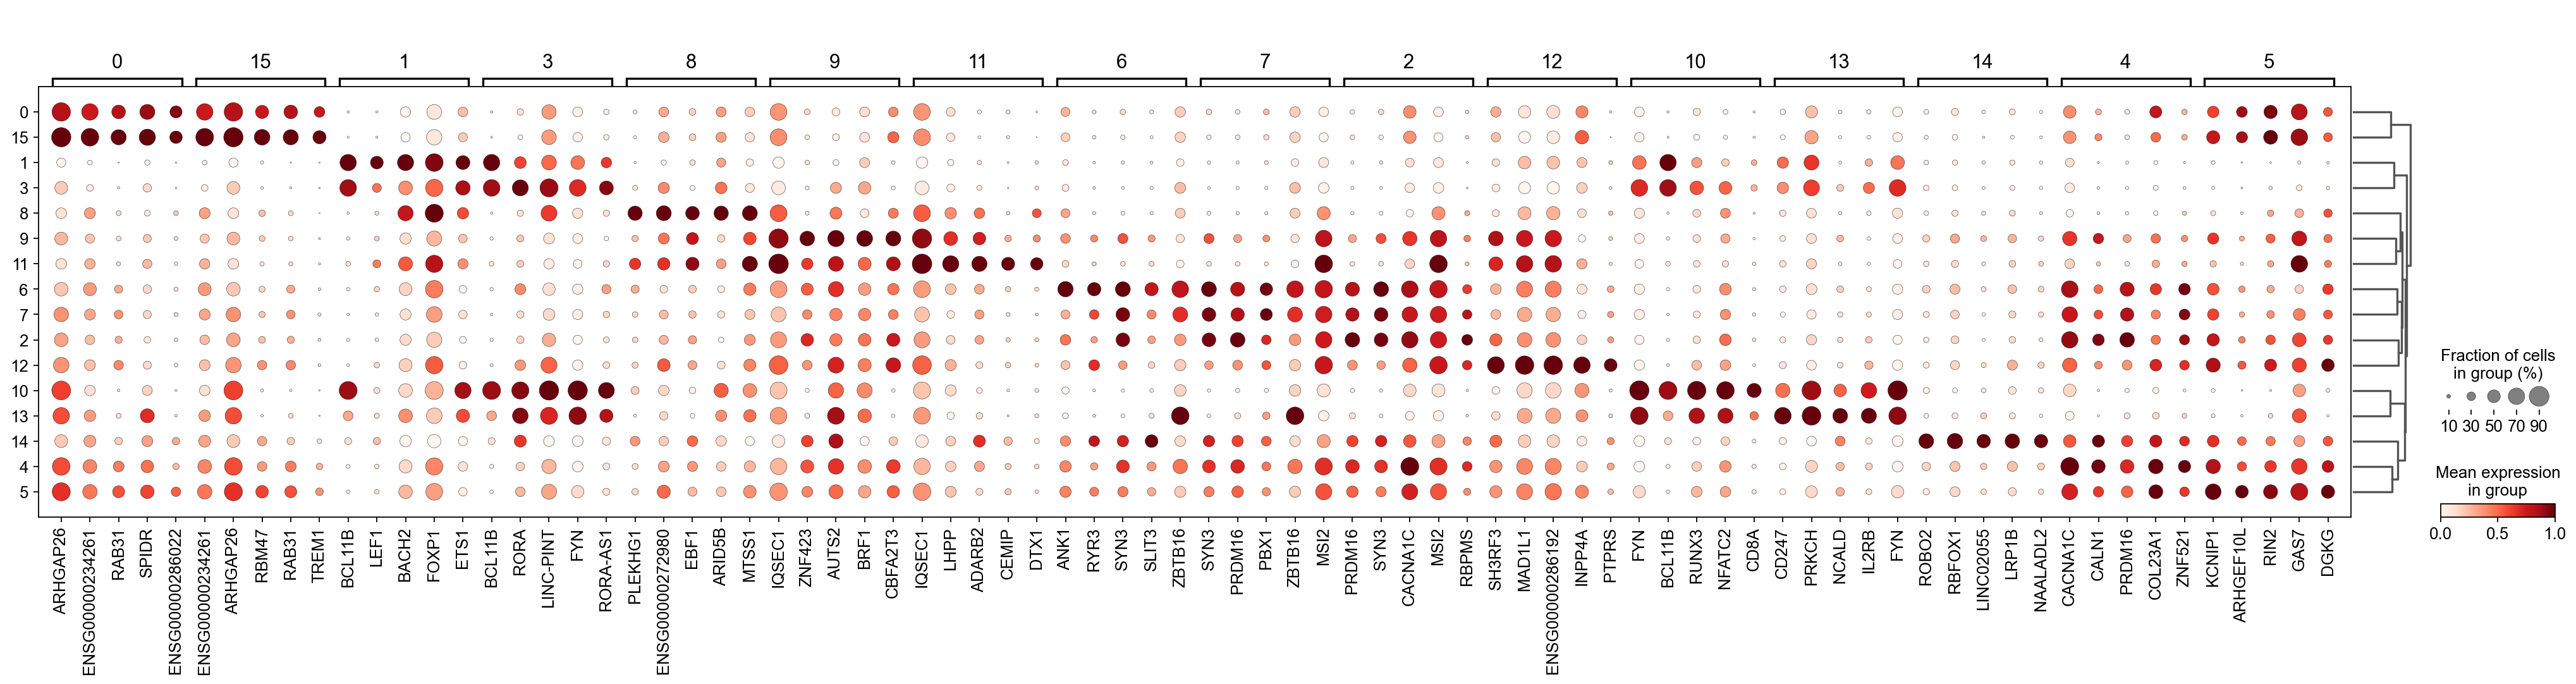

In [59]:
sc.tl.dendrogram(gene_act,use_rep='X_lsi',groupby='leiden')
sc.pl.rank_genes_groups_dotplot(
    gene_act, groupby="leiden", standard_scale="var", n_genes=5
)

In [65]:
#['CD163', 'CD1C', 'CLEC9A', 'FCGR3B', 'LILRB2', 'S100A12', 'TPSAB1']
small_marker_dict={
    'Fibroblast':['ACTA2'],
    'Endothelium':['PTPRB','PECAM1'],
    'Epithelium':['KRT5','KRT14'],
    'Mast cell':['KIT','CD63'],
    'Neutrophil' :['FCGR3A','ITGAM'],
    'cDendritic cell':['FCER1A','CST3'],
    'pDendritic cell':['IL3RA','GZMB','SERPINF1','ITM2C'],
    'Monocyte' :['CD14','LYZ','S100A8','S100A9','LST1',],
    'Macrophage':['CSF1R','CD68'],
    'B cell':['MS4A1','CD79A'],
    'Plasma cell':['MZB1','IGKC','JCHAIN'],
    'Proliferative signal':['MKI67','TOP2A','STMN1'],
    'NK/NKT cell':['GNLY','NKG7','KLRD1'],
    'T cell':['CD3D','CD3E'],
}
# check if the markers are in the data
smarker_genes_in_data = dict()
for ct, markers in small_marker_dict.items():
    markers_found = list()
    for marker in markers:
        if marker in gene_act.var.index:
            markers_found.append(marker)
    smarker_genes_in_data[ct] = markers_found
#del [] # remove the last marker
del_markers = list()
for ct, markers in smarker_genes_in_data.items():
    if markers==[]:
        del_markers.append(ct)
for ct in del_markers:
    del smarker_genes_in_data[ct]



In [66]:
smarker_genes_in_data


{'Fibroblast': ['ACTA2'],
 'Endothelium': ['PTPRB'],
 'Mast cell': ['KIT', 'CD63'],
 'Neutrophil': ['FCGR3A', 'ITGAM'],
 'cDendritic cell': ['FCER1A', 'CST3'],
 'pDendritic cell': ['IL3RA', 'GZMB', 'SERPINF1', 'ITM2C'],
 'Monocyte': ['CD14', 'LYZ', 'S100A8', 'S100A9', 'LST1'],
 'Macrophage': ['CSF1R', 'CD68'],
 'B cell': ['MS4A1', 'CD79A'],
 'Plasma cell': ['MZB1'],
 'Proliferative signal': ['MKI67', 'TOP2A', 'STMN1'],
 'NK/NKT cell': ['GNLY', 'NKG7', 'KLRD1'],
 'T cell': ['CD3D', 'CD3E']}

categories: 0, 1, 2, etc.
var_group_labels: Fibroblast, Endothelium, Mast cell, etc.


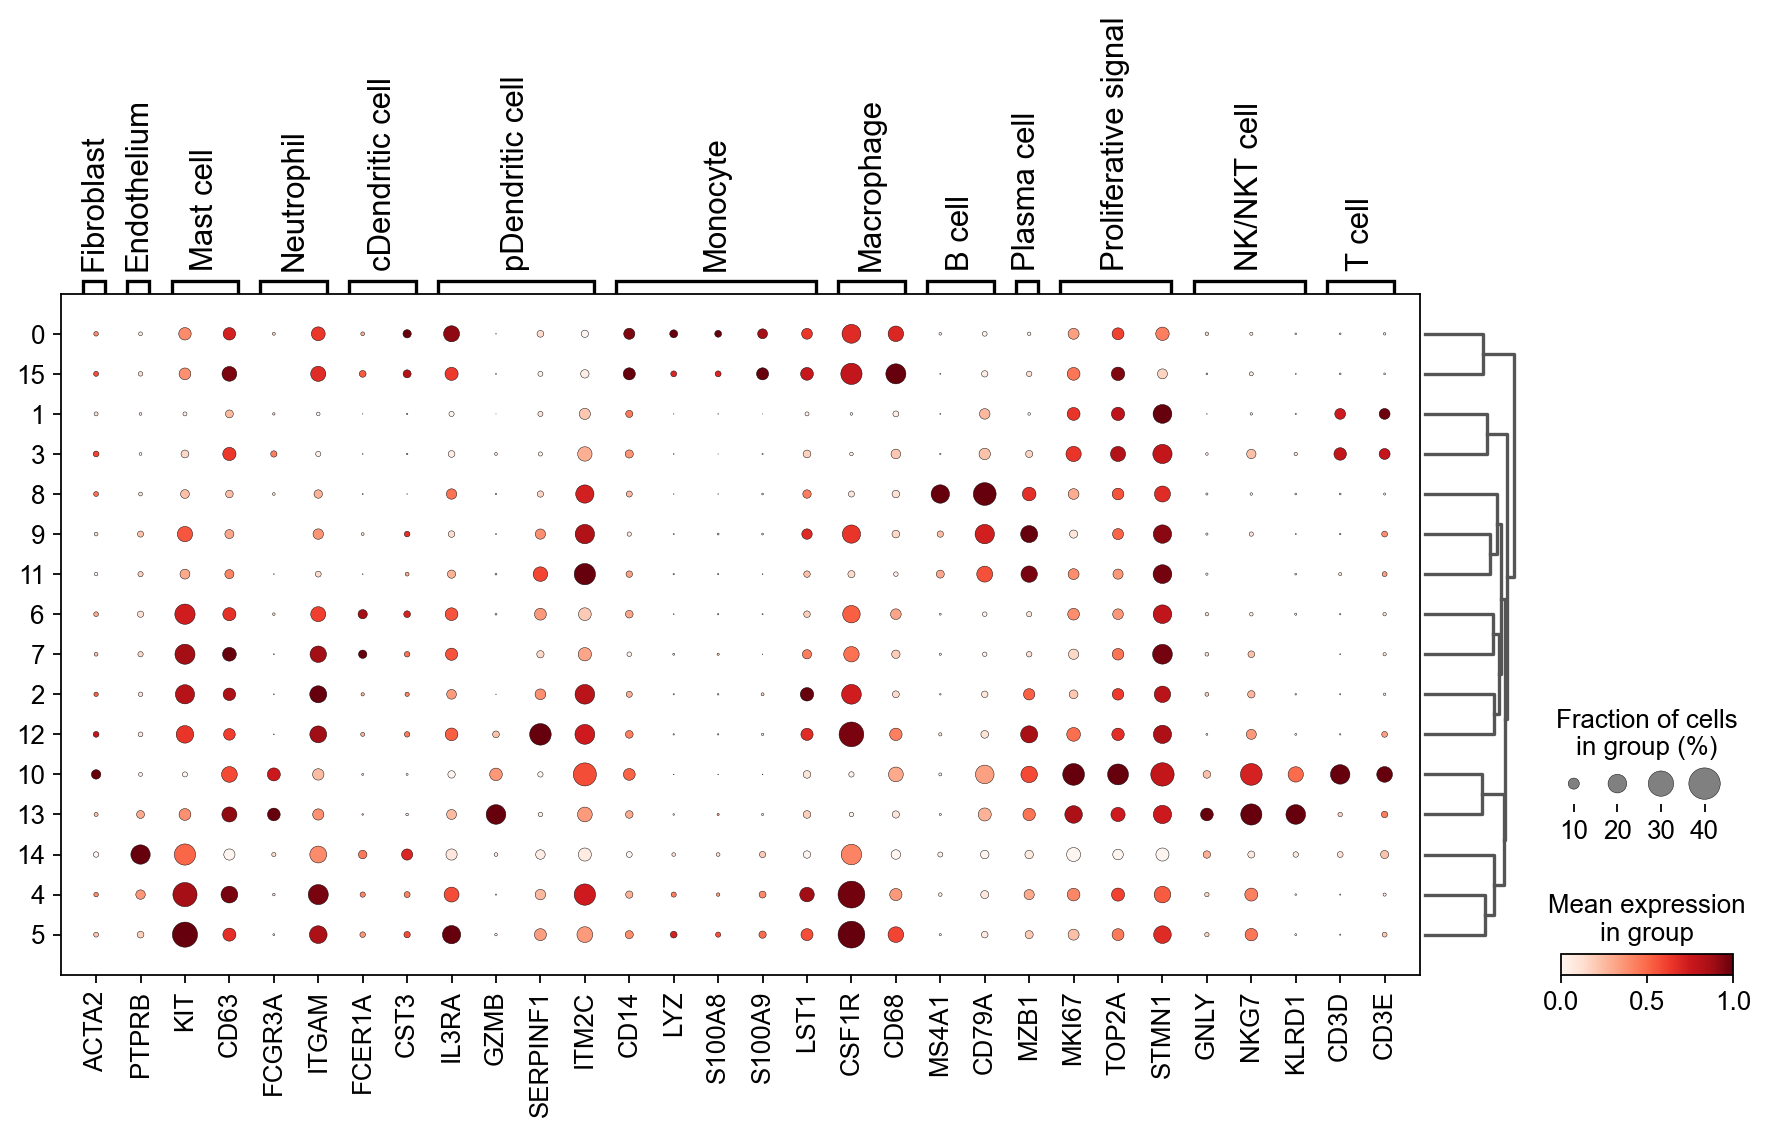

In [67]:
sc.pl.dotplot(
    gene_act,
    groupby="leiden",
    var_names=smarker_genes_in_data,
    dendrogram=True,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
)


In [125]:
#这是一个空字典用于复制粘贴
cluster2annotation = {
     '0': 'Mono',
     '1': 'T cells',
     '2': 'HSC',
     '3': 'T cells',
     '4': 'CMP_LMPP',
     '5': 'CLP',
     '6': 'Late Ery',
     '7': 'Early Ery',
     '8': 'B cells',
     '9': 'pre-B',
     '10': 'NKT',
     '11': 'pre-B',#CD79A⁺ / MS4A1(CD20)⁻
     '12': 'pDC',
     '13': 'NK',
     '14': 'Endo',
     '15': 'Mono',

}
gene_act.obs['major_celltype'] = gene_act.obs['leiden'].map(cluster2annotation).astype('category')


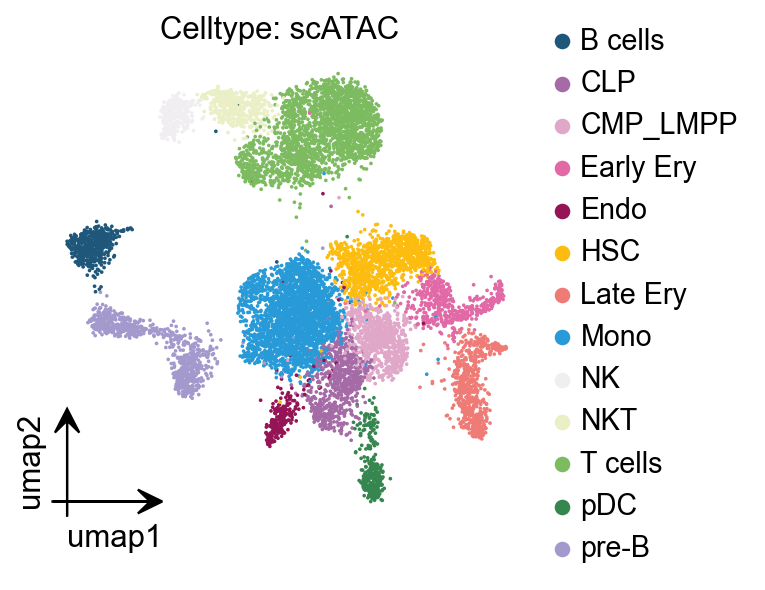

In [126]:
epi.pl.umap(
    gene_act,
    #basis='X_umap',
    color='major_celltype',
    title='Celltype: scATAC',
    cmap='Reds',
    vmax='p99.2',
)

In [127]:
gene_act.write('data/pbmc_gene_act_anno.h5ad')

In [128]:
peak_mat.obs['celltype']=gene_act.obs['major_celltype']

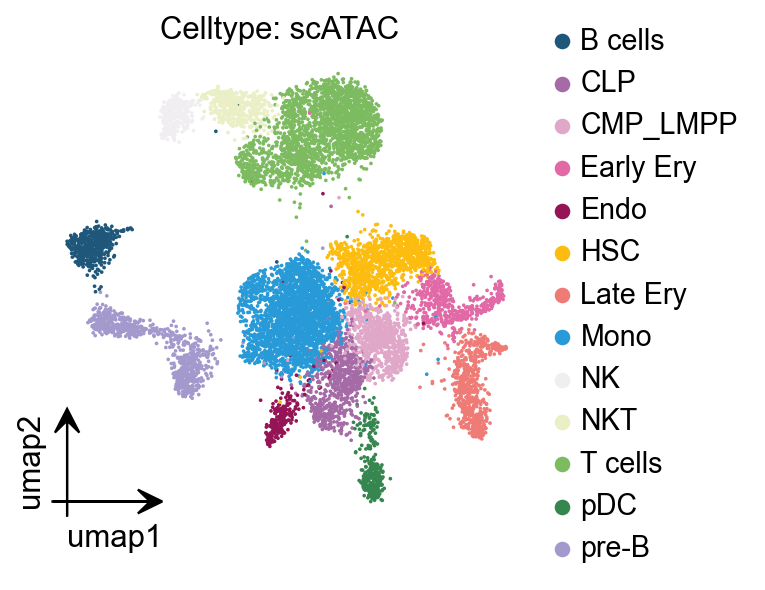

In [129]:
epi.pl.umap(
    peak_mat,
    #basis='X_umap',
    color='celltype',
    title='Celltype: scATAC',
    #palette=
    cmap='Reds',
    vmax='p99.2',
)

In [130]:
peak_mat.write('data/pbmc_peak_mat_anno.h5ad')

## Peak calling Again

In [133]:
%%time
data = snap.AnnDataSet(
    adatas=[(name, adata) for (name, _), adata in zip(files, adatas)],
    filename="data/pbmc_new1.h5ads"
)
data

CPU times: user 9.38 ms, sys: 8.56 ms, total: 17.9 ms
Wall time: 27 ms


AnnDataSet object with n_obs x n_vars = 10889 x 0 backed at 'data/pbmc_new1.h5ads'
contains 3 AnnData objects with keys: 'scATAC_BMMC_R1', 'scATAC_CD34_BMMC_R1', 'scATAC_PBMC_R1'
    obs: 'sample'
    uns: 'AnnDataSet', 'reference_sequences'

In [134]:
data.obs['celltype']=peak_mat.obs.loc[data.obs_names,'celltype'].tolist()

In [135]:
%%time
snap.tl.macs3(data, groupby='celltype', replicate='sample')

2025-10-10 00:57:40 - INFO - Exporting fragments...
2025-10-10 00:57:51 - INFO - Calling peaks...
100%|███████████████████████████████████████████████████████████████████████████| 13/13 [05:15<00:00, 24.26s/it]


CPU times: user 26.2 s, sys: 2.88 s, total: 29.1 s
Wall time: 5min 27s


In [137]:
data

AnnDataSet object with n_obs x n_vars = 10889 x 0 backed at 'data/pbmc_new1.h5ads'
contains 3 AnnData objects with keys: 'scATAC_BMMC_R1', 'scATAC_CD34_BMMC_R1', 'scATAC_PBMC_R1'
    obs: 'sample', 'celltype'
    uns: 'macs3', 'AnnDataSet', 'reference_sequences'

In [138]:
%%time
merged_peaks = epi.utils.merge_peaks(data.uns['macs3'], epi.utils.hg19)
merged_peaks.head()

CPU times: user 125 ms, sys: 32.8 ms, total: 158 ms
Wall time: 173 ms


Peaks,B cells,CLP,Late Ery,HSC,pDC,NKT,pre-B,T cells,NK,Early Ery,Endo,CMP_LMPP,Mono
str,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool
"""chr1:713834-714335""",false,true,false,false,false,false,false,true,true,false,false,false,true
"""chr1:762667-763168""",false,false,false,false,false,false,false,false,true,false,false,false,true
"""chr1:805018-805519""",false,true,false,false,false,false,false,false,true,false,false,false,true
"""chr1:839884-840385""",false,false,false,false,false,false,false,false,true,false,false,false,false
"""chr1:894455-894956""",false,false,false,false,false,false,false,false,true,false,false,false,true


In [139]:
%%time
peak_mat1= epi.pp.make_peak_matrix(data, use_rep=merged_peaks['Peaks'])
peak_mat1

CPU times: user 17.6 s, sys: 797 ms, total: 18.4 s
Wall time: 5.35 s


AnnData object with n_obs × n_vars = 10889 × 31779
    obs: 'sample', 'celltype'

Since we are using `anndata-rs` to read data stored on the hard disk, we need to perform a close operation to ensure data integrity and security.

In [140]:
data.close()

In [142]:
peak_mat1.obsm=peak_mat.obsm.copy()
peak_mat1.obsp=peak_mat.obsp.copy()

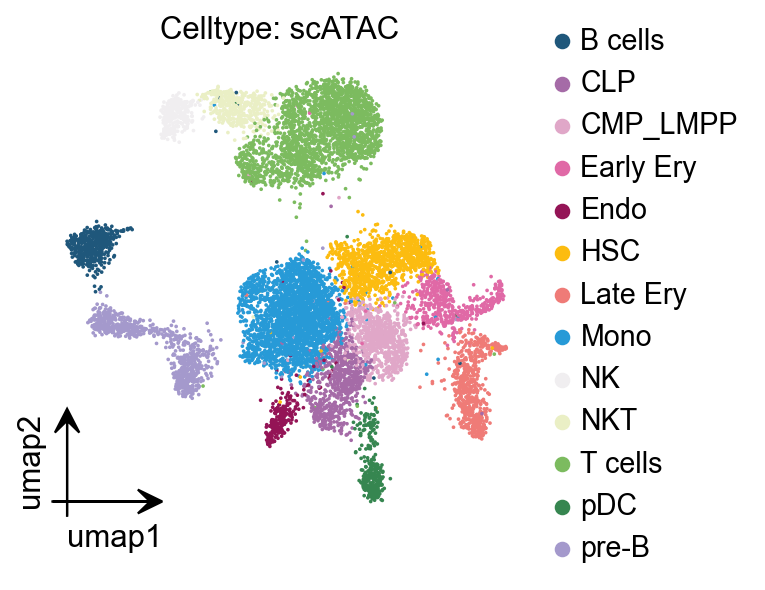

In [146]:
epi.pl.umap(
    peak_mat1,
    #basis='X_umap',
    color='celltype',
    title='Celltype: scATAC',
    #palette=
    cmap='Reds',
    vmax='p99.2',
)

In [147]:
peak_mat1.write('data/pbmc_peak_calling.h5ad')